# Task 2 - Predict customer buying behaviour

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


%matplotlib inline

In [7]:
data= 'customer_booking.csv'

In [9]:
with open(data, 'rb') as rawdata:
  result = chardet.detect(rawdata.read(100000))

print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [10]:
df= pd.read_csv(data, encoding='ISO-8859-1')

In [11]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


# Exploratory Data Analysis

In [14]:
df.dtypes

,0
num_passengers,int64
sales_channel,object
trip_type,object
purchase_lead,int64
length_of_stay,int64
flight_hour,int64
flight_day,object
route,object
booking_origin,object
wants_extra_baggage,int64


In [15]:
df.shape

(50000, 14)

In [16]:
df.isnull().sum()

,0
num_passengers,0
sales_channel,0
trip_type,0
purchase_lead,0
length_of_stay,0
flight_hour,0
flight_day,0
route,0
booking_origin,0
wants_extra_baggage,0


In [17]:
df.booking_complete.value_counts()

,count
booking_complete,
0,42522
1,7478


# Mutual Information

In [18]:
X= df.drop('booking_complete',axis=1)
y= df.booking_complete

#changing object dtype to int dtype
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [19]:
X.dtypes

,0
num_passengers,int64
sales_channel,int64
trip_type,int64
purchase_lead,int64
length_of_stay,int64
flight_hour,int64
flight_day,int64
route,int64
booking_origin,int64
wants_extra_baggage,int64


In [21]:
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores # show a few features with their MI scores

,MI Scores
route,0.053153
booking_origin,0.047560
flight_duration,0.017713
wants_extra_baggage,0.008922
length_of_stay,0.006044
wants_in_flight_meals,0.005960
wants_preferred_seat,0.003184
flight_hour,0.003088
num_passengers,0.002721
trip_type,0.001927


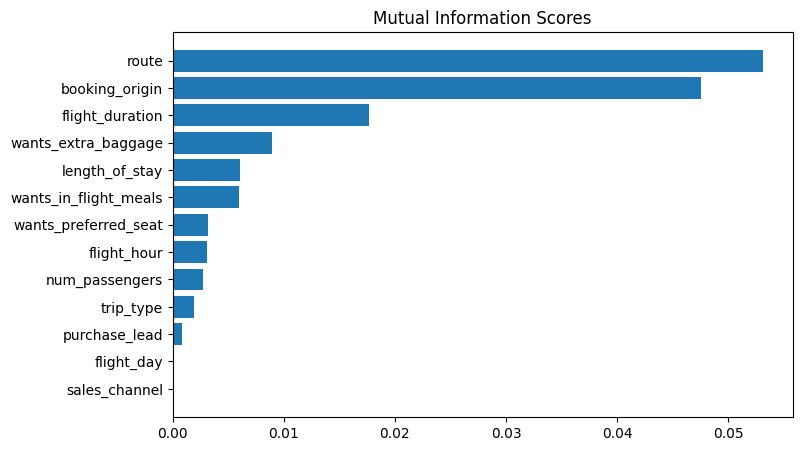

In [22]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

We can see

1.   route
2.   booking_origin
3.   flight_duration          
4.   wants_extra_baggage      
5.   length_of_stay          

 are the top 5 features which are dependant with booking_complete feature

In [25]:
# dataset split
# creating a function for dataset split
def dataset(X,y):
    train_full_X, val_X, train_full_y, val_y = train_test_split(X, y,test_size=0.2,random_state = 0)

    # Use the same function above for the validation set
    train_X, test_X, train_y, test_y = train_test_split(train_full_X, train_full_y, test_size=0.25,random_state = 0)
    return (train_X, val_X, train_y, val_y)

In [27]:
def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    return X

# Model 1 : Random forest classifier with top 6 features

In [29]:
#assigning the features under a list

features=['route','booking_origin','flight_duration','wants_extra_baggage', 'length_of_stay','num_passengers']
X= df[features]
#one hot encoding
X = pd.get_dummies(X, columns=features)
X= scale(X)
y= df.booking_complete

X_train,X_val,y_train,y_val= dataset(X,y)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  83.36
AUC score:  0.5657818407546988


# Model 2 : Random forest classifier with all features

In [30]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete

X_train,X_val,y_train,y_val= dataset(X,y)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  84.76
AUC score:  0.5479604084813514


# Model 3 : XGB classifier with top 6 features

In [32]:
X= df[features]

#one hot encoding
X = pd.get_dummies(X, columns=features)
X= scale(X)

y= df.booking_complete

X_train,X_val,y_train,y_val= dataset(X,y)
xgb_model = XGBClassifier()

xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)
print('ACCURACY: ',accuracy_score(y_val, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_val,prediction_xgb))

ACCURACY:  84.72
AUC score:  0.5189398567740671


# Model 4 : XGB classifier with all features

In [33]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete

X_train,X_val,y_train,y_val= dataset(X,y)


xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)
print('ACCURACY: ',accuracy_score(y_val, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_val,prediction_xgb))

ACCURACY:  84.98
AUC score:  0.5424676175552812


Finalizing random forest model with all features as final model, as it has goos accuracy and higher auc score compared to other models

Validating with test data set

In [34]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete

train_full_X,test_X, train_full_y, test_y = train_test_split(X, y,test_size=0.2,random_state = 0)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(train_full_X, train_full_y)
preds= forest_model.predict(test_X)

print('ACCURACY: ',accuracy_score(test_y,preds)*100)
print('AUC score: ',roc_auc_score(test_y,preds))

ACCURACY:  85.09
AUC score:  0.5577796717361984
